# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_125  P15151-2         15.595
Sample_175  Q99538           18.637
Sample_138  Q6MZW2           16.375
Sample_135  P24592           21.205
Sample_103  P05408-2         21.154
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                   
Sample_149  P12273                              11.036
Sample_181  P04040                              12.276
Sample_054  P19367;P19367-2;P19367-3;P19367-4   14.158
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.295
            A0A075B6Q5                 13.900
            A0A075B6R2                 13.944
            A0A075B6S5                 14.085
            A0A087WSY4                 12.223
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.216
            Q9UI40;Q9UI40-2            11.529
            Q9UIW2                     12.056
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.620
            Q9UP79                     14.919
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.226,15.050,16.842,19.863,13.789,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.152,19.067,...,15.528,15.576,13.067,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,12.636,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.461,17.705,17.039,13.505,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,11.981,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.398,15.345,17.084,18.708,14.249,19.433,10.971,9.558
Sample_207,15.739,16.877,15.469,16.898,14.164,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.944,12.170,12.884,12.463,12.662,13.284,12.915,14.199,13.815,12.479
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.201,19.067,16.127,...,12.773,12.653,13.443,12.985,13.099,13.042,13.245,12.509,13.410,12.435
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.746,13.016,12.327,12.901,12.536,12.802,12.347,12.822,12.627,12.377
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.200,13.256,12.486,11.258,12.327,11.603,12.225,13.926,13.255,13.023
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.250,13.752,13.620,13.933,13.005,13.228,12.510,14.075,14.145,13.322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.430,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 325.39it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.95it/s]

100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

100%|██████████| 3/3 [00:00<00:00,  6.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.47it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.95it/s]

100%|██████████| 4/4 [00:00<00:00,  3.94it/s]

100%|██████████| 4/4 [00:00<00:00,  4.41it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.85it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.51it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.71it/s]

100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.48it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.40it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.05it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.76it/s]

100%|██████████| 6/6 [00:01<00:00,  2.73it/s]

100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.77it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.80it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.44it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.04it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.04it/s]

100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.06it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.79it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.97it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.87it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.64it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.54it/s]

100%|██████████| 8/8 [00:02<00:00,  3.79it/s]

100%|██████████| 8/8 [00:02<00:00,  3.83it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.60it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.55it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.01it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.93it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.00it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.93it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.10it/s]

100%|██████████| 9/9 [00:02<00:00,  4.10it/s]

100%|██████████| 9/9 [00:02<00:00,  4.18it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.49it/s]

 30%|███       | 3/10 [00:00<00:01,  6.17it/s]

 40%|████      | 4/10 [00:00<00:01,  5.19it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.93it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.72it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.07it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.72it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.47it/s]

100%|██████████| 10/10 [00:02<00:00,  3.31it/s]

100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.98it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.34it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.57it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.37it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.88it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.63it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.33it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.40it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.22it/s]

100%|██████████| 11/11 [00:02<00:00,  3.42it/s]

100%|██████████| 11/11 [00:02<00:00,  3.86it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.09it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.91it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.94it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.64it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.34it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.05it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.00it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.93it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.90it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.78it/s]

100%|██████████| 12/12 [00:03<00:00,  2.88it/s]

100%|██████████| 12/12 [00:03<00:00,  3.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.80it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.65it/s]

 31%|███       | 4/13 [00:00<00:02,  3.82it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.47it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.56it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.46it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.62it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.32it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.12it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.90it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.69it/s]

100%|██████████| 13/13 [00:04<00:00,  2.77it/s]

100%|██████████| 13/13 [00:04<00:00,  3.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.20it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.06it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.47it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.17it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.03it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.17it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.36it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.33it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.16it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.98it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.95it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.10it/s]

100%|██████████| 14/14 [00:04<00:00,  3.29it/s]

100%|██████████| 14/14 [00:04<00:00,  3.30it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.65it/s]

 20%|██        | 3/15 [00:00<00:02,  5.28it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.99it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.50it/s]

 40%|████      | 6/15 [00:01<00:02,  3.18it/s]

 47%|████▋     | 7/15 [00:01<00:02,  2.94it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.93it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.04it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.16it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.90it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.06it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.92it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.72it/s]

100%|██████████| 15/15 [00:04<00:00,  2.61it/s]

100%|██████████| 15/15 [00:04<00:00,  3.09it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.038 0.013          0.811 0.297       0.136   
2             0.004 0.003      0.056 0.026          0.707 0.107       0.617   
3             0.005 0.005      0.057 0.027          0.798 0.077       0.726   
4             0.004 0.004      0.045 0.020          0.797 0.078       0.740   
5             0.005 0.004      0.051 0.024          0.800 0.079       0.740   
6             0.004 0.002      0.042 0.014          0.803 0.091       0.766   
7             0.004 0.002      0.044 0.016          0.796 0.091       0.763   
8             0.005 0.003      0.052 0.020          0.798 0.094       0.751   
9             0.006 0.005      0.073 0.025          0.796 0.094       0.741   
10            0.007 0.006      0.061 0.023          0.808 0.077       0.811   
11            0.006 0.007      0.060 0.029          0.803 0.080       0.809   
12            0.006 0.007      0.052 0.023          0.806 0.080       0.818   
13            0.005 0.005      0.043 0.013          0.815 0.078       0.838   
14            0.004 0.002      0.047 0.020          0.812 0.082       0.819   
15            0.006 0.004      0.049 0.019          0.819 0.075       0.823   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.226 0.124                  0.560 0.041        0.861   
2          0.114   0.649 0.081                  0.710 0.059        0.779   
3          0.120   0.755 0.085                  0.796 0.066        0.872   
4          0.106   0.764 0.080                  0.801 0.063        0.875   
5          0.105   0.765 0.080                  0.802 0.063        0.874   
6          0.120   0.780 0.091                  0.814 0.073        0.880   
7          0.116   0.775 0.088                  0.809 0.071        0.876   
8          0.116   0.769 0.088                  0.805 0.070        0.880   
9          0.124   0.763 0.096                  0.801 0.075        0.878   
10         0.114   0.804 0.074                  0.834 0.062        0.911   
11         0.116   0.802 0.083                  0.832 0.069        0.912   
12         0.112   0.808 0.079                  0.836 0.065        0.912   
13         0.095   0.823 0.070                  0.849 0.060        0.918   
14         0.099   0.812 0.075                  0.840 0.064        0.917   
15         0.098   0.818 0.072                  0.845 0.060        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.830 0.090        210.000 0.000  
2          0.073                  0.705 0.097        210.000 0.000  
3          0.059                  0.858 0.065        210.000 0.000  
4          0.056                  0.859 0.065        210.000 0.000  
5          0.056                  0.854 0.069        210.000 0.000  
6          0.061                  0.872 0.066        210.000 0.000  
7          0.062                  0.867 0.068        210.000 0.000  
8          0.061                  0.870 0.066        210.000 0.000  
9          0.063                  0.866 0.069        210.000 0.000  
10         0.049                  0.894 0.054        210.000 0.000  
11         0.050                  0.896 0.055        210.000 0.000  
12         0.050                  0.899 0.052        210.000 0.000  
13         0.047                  0.908 0.048        210.000 0.000  
14         0.049                  0.906 0.049        210.000 0.000  
15         0.048                  0.903 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 467.70it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.19it/s]

100%|██████████| 3/3 [00:00<00:00,  4.00it/s]

100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.54it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.52it/s]

100%|██████████| 4/4 [00:00<00:00,  3.76it/s]

100%|██████████| 4/4 [00:00<00:00,  4.14it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.88it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.99it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.01it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.97it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.49it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

100%|██████████| 6/6 [00:01<00:00,  4.21it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.71it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.38it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.58it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.39it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.32it/s]

100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.90it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.84it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.31it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.17it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.92it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.95it/s]

100%|██████████| 8/8 [00:01<00:00,  3.96it/s]

100%|██████████| 8/8 [00:01<00:00,  4.24it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.81it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.03it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.76it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.54it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.60it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.51it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.51it/s]

100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.73it/s]

 30%|███       | 3/10 [00:00<00:01,  4.56it/s]

 40%|████      | 4/10 [00:00<00:01,  3.68it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.58it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.36it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.40it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.58it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.70it/s]

100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.48it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.32it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.57it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.23it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.79it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.50it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.35it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.59it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.66it/s]

100%|██████████| 11/11 [00:03<00:00,  2.78it/s]

100%|██████████| 11/11 [00:03<00:00,  2.99it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.71it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.09it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.92it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.89it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.60it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.13it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.31it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.21it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.16it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.30it/s]

100%|██████████| 12/12 [00:03<00:00,  3.27it/s]

100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.47it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.25it/s]

 31%|███       | 4/13 [00:00<00:01,  4.58it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.17it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.66it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.19it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.51it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.41it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.43it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.48it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.56it/s]

100%|██████████| 13/13 [00:04<00:00,  2.81it/s]

100%|██████████| 13/13 [00:04<00:00,  3.03it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.95it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.88it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.50it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.48it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.53it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.72it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.76it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.83it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.93it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.60it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.46it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.49it/s]

100%|██████████| 14/14 [00:05<00:00,  2.42it/s]

100%|██████████| 14/14 [00:05<00:00,  2.61it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.50it/s]

 20%|██        | 3/15 [00:00<00:03,  3.71it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.39it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.31it/s]

 40%|████      | 6/15 [00:01<00:03,  2.90it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.75it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.66it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.60it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.79it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.95it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.58it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.47it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.36it/s]

100%|██████████| 15/15 [00:05<00:00,  2.26it/s]

100%|██████████| 15/15 [00:05<00:00,  2.69it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.070 0.020          0.792 0.317       0.130   
2             0.004 0.002      0.043 0.015          0.679 0.114       0.528   
3             0.007 0.008      0.061 0.022          0.786 0.085       0.737   
4             0.004 0.003      0.049 0.018          0.790 0.082       0.757   
5             0.005 0.007      0.047 0.020          0.787 0.088       0.774   
6             0.004 0.002      0.036 0.002          0.797 0.097       0.749   
7             0.003 0.000      0.036 0.008          0.784 0.097       0.759   
8             0.004 0.002      0.037 0.011          0.781 0.090       0.776   
9             0.004 0.004      0.039 0.010          0.781 0.091       0.784   
10            0.004 0.003      0.051 0.020          0.792 0.094       0.800   
11            0.005 0.003      0.042 0.012          0.808 0.088       0.789   
12            0.005 0.004      0.049 0.019          0.840 0.083       0.832   
13            0.005 0.003      0.040 0.012          0.839 0.083       0.846   
14            0.007 0.006      0.075 0.033          0.831 0.078       0.838   
15            0.005 0.003      0.044 0.019          0.845 0.086       0.840   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.216 0.130                  0.557 0.043        0.849   
2          0.122   0.585 0.094                  0.670 0.061        0.730   
3          0.107   0.755 0.077                  0.793 0.062        0.876   
4          0.110   0.768 0.076                  0.804 0.061        0.878   
5          0.102   0.776 0.071                  0.808 0.059        0.878   
6          0.100   0.766 0.065                  0.801 0.054        0.879   
7          0.108   0.765 0.076                  0.800 0.063        0.901   
8          0.107   0.772 0.069                  0.806 0.057        0.900   
9          0.109   0.776 0.070                  0.809 0.059        0.900   
10         0.103   0.790 0.071                  0.820 0.061        0.902   
11         0.108   0.792 0.070                  0.823 0.059        0.905   
12         0.082   0.832 0.062                  0.856 0.054        0.918   
13         0.084   0.839 0.063                  0.862 0.054        0.916   
14         0.080   0.831 0.056                  0.855 0.049        0.916   
15         0.082   0.839 0.061                  0.862 0.053        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.824 0.088        210.000 0.000  
2          0.072                  0.694 0.084        210.000 0.000  
3          0.052                  0.862 0.057        210.000 0.000  
4          0.052                  0.863 0.056        210.000 0.000  
5          0.053                  0.866 0.056        210.000 0.000  
6          0.052                  0.865 0.057        210.000 0.000  
7          0.050                  0.878 0.058        210.000 0.000  
8          0.050                  0.878 0.057        210.000 0.000  
9          0.050                  0.877 0.059        210.000 0.000  
10         0.050                  0.880 0.060        210.000 0.000  
11         0.050                  0.880 0.060        210.000 0.000  
12         0.049                  0.905 0.050        210.000 0.000  
13         0.052                  0.904 0.055        210.000 0.000  
14         0.052                  0.905 0.055        210.000 0.000  
15         0.050                  0.912 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1099.71it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.86it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 30.47it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 24.64it/s]

100%|██████████| 4/4 [00:00<00:00, 18.20it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 25.05it/s]

100%|██████████| 5/5 [00:00<00:00, 20.03it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.52it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 17.18it/s]

100%|██████████| 6/6 [00:00<00:00, 15.85it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 25.45it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 18.28it/s]

100%|██████████| 7/7 [00:00<00:00, 19.02it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.97it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.56it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.13it/s]

100%|██████████| 8/8 [00:00<00:00, 13.25it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.29it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.12it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.91it/s]

100%|██████████| 9/9 [00:00<00:00, 16.63it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 22.04it/s]

 60%|██████    | 6/10 [00:00<00:00, 16.50it/s]

 80%|████████  | 8/10 [00:00<00:00, 16.03it/s]

100%|██████████| 10/10 [00:00<00:00, 15.46it/s]

100%|██████████| 10/10 [00:00<00:00, 16.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 23.12it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 17.17it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 15.62it/s]

 91%|█████████ | 10/11 [00:00<00:00, 15.56it/s]

100%|██████████| 11/11 [00:00<00:00, 16.54it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.12it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.43it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.53it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.33it/s]

100%|██████████| 12/12 [00:00<00:00, 14.66it/s]

100%|██████████| 12/12 [00:00<00:00, 15.12it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.79it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.27it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 17.20it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.29it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.75it/s]

100%|██████████| 13/13 [00:00<00:00, 15.54it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 21.22it/s]

 43%|████▎     | 6/14 [00:00<00:00, 14.10it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 13.83it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.99it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.98it/s]

100%|██████████| 14/14 [00:01<00:00, 12.02it/s]

100%|██████████| 14/14 [00:01<00:00, 13.02it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.03it/s]

 40%|████      | 6/15 [00:00<00:00, 14.01it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.18it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.61it/s]

 80%|████████  | 12/15 [00:00<00:00, 12.27it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 12.15it/s]

100%|██████████| 15/15 [00:01<00:00, 12.89it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.044 0.015          0.471 0.477       0.040   
2             0.004 0.004      0.037 0.009          0.500 0.377       0.096   
3             0.004 0.003      0.041 0.015          0.572 0.358       0.106   
4             0.004 0.002      0.041 0.013          0.656 0.212       0.225   
5             0.004 0.003      0.048 0.021          0.606 0.224       0.218   
6             0.004 0.004      0.038 0.014          0.569 0.214       0.227   
7             0.004 0.002      0.046 0.020          0.529 0.196       0.212   
8             0.007 0.007      0.065 0.027          0.513 0.194       0.205   
9             0.007 0.008      0.061 0.029          0.552 0.119       0.453   
10            0.006 0.005      0.053 0.022          0.522 0.099       0.445   
11            0.006 0.005      0.060 0.027          0.517 0.106       0.439   
12            0.006 0.005      0.058 0.020          0.544 0.121       0.457   
13            0.005 0.004      0.045 0.015          0.551 0.106       0.479   
14            0.004 0.003      0.047 0.016          0.542 0.108       0.471   
15            0.006 0.004      0.051 0.019          0.537 0.110       0.471   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.050   0.072 0.084                  0.515 0.025        0.717   
2          0.083   0.152 0.123                  0.524 0.037        0.675   
3          0.084   0.168 0.120                  0.529 0.036        0.642   
4          0.111   0.313 0.121                  0.557 0.052        0.609   
5          0.109   0.301 0.118                  0.549 0.049        0.593   
6          0.115   0.306 0.127                  0.544 0.056        0.566   
7          0.100   0.287 0.111                  0.527 0.056        0.544   
8          0.101   0.277 0.111                  0.523 0.052        0.527   
9          0.113   0.487 0.092                  0.586 0.066        0.646   
10         0.100   0.474 0.086                  0.571 0.064        0.642   
11         0.112   0.468 0.098                  0.568 0.068        0.635   
12         0.108   0.488 0.090                  0.582 0.071        0.651   
13         0.088   0.506 0.077                  0.591 0.067        0.654   
14         0.087   0.498 0.078                  0.585 0.068        0.645   
15         0.097   0.496 0.086                  0.582 0.073        0.636   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.670 0.078        210.000 0.000  
2          0.088                  0.631 0.093        210.000 0.000  
3          0.090                  0.614 0.100        210.000 0.000  
4          0.088                  0.573 0.099        210.000 0.000  
5          0.086                  0.558 0.099        210.000 0.000  
6          0.086                  0.530 0.098        210.000 0.000  
7          0.087                  0.504 0.085        210.000 0.000  
8          0.083                  0.483 0.074        210.000 0.000  
9          0.077                  0.580 0.082        210.000 0.000  
10         0.075                  0.572 0.080        210.000 0.000  
11         0.075                  0.561 0.081        210.000 0.000  
12         0.072                  0.609 0.085        210.000 0.000  
13         0.071                  0.603 0.087        210.000 0.000  
14         0.070                  0.593 0.085        210.000 0.000  
15         0.071                  0.588 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,10,14,8
score_time,9,14,8
test_precision,15,15,4
test_recall,13,13,13
test_f1,13,15,13
test_balanced_accuracy,13,15,13
test_roc_auc,13,15,1
test_average_precision,13,15,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.34it/s]

 20%|██        | 3/15 [00:00<00:03,  3.71it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.63it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.54it/s]

 40%|████      | 6/15 [00:01<00:02,  3.42it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.28it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.85it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.77it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.65it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.74it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.90it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.99it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.08it/s]

100%|██████████| 15/15 [00:04<00:00,  3.14it/s]

100%|██████████| 15/15 [00:04<00:00,  3.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1016.06it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.02it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.19it/s]

 31%|███       | 4/13 [00:01<00:02,  3.48it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.51it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.52it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.46it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.40it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.13it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  3.00it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.72it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.78it/s]

100%|██████████| 13/13 [00:03<00:00,  3.06it/s]

100%|██████████| 13/13 [00:03<00:00,  3.26it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


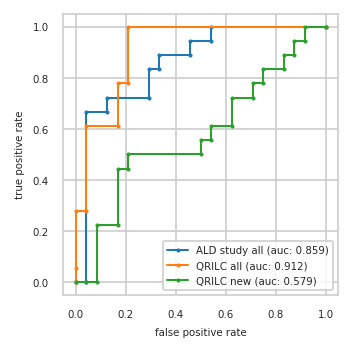

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.042 0.000     0.000 0.056     0.042 0.000
2          0.042 0.667     0.000 0.278     0.083 0.000
3          0.125 0.667     0.042 0.278     0.083 0.222
4          0.125 0.722     0.042 0.611     0.167 0.222
5          0.292 0.722     0.167 0.611     0.167 0.444
6          0.292 0.833     0.167 0.778     0.208 0.444
7          0.333 0.833     0.208 0.778     0.208 0.500
8          0.333 0.889     0.208 1.000     0.500 0.500
9          0.458 0.889     1.000 1.000     0.500 0.556
10         0.458 0.944       NaN   NaN     0.542 0.556
11         0.542 0.944       NaN   NaN     0.542 0.611
12         0.542 1.000       NaN   NaN     0.625 0.611
13         1.000 1.000       NaN   NaN     0.625 0.722
14           NaN   NaN       NaN   NaN     0.708 0.722
15           NaN   NaN       NaN   NaN     0.708 0.778
16           NaN   NaN       NaN   NaN     0.750 0.778
17           NaN   NaN       NaN   NaN     0.750 0.833
18           NaN   NaN       NaN   NaN     0.833 0.833
19           NaN   NaN       NaN   NaN     0.833 0.889
20           NaN   NaN       NaN   NaN     0.875 0.889
21           NaN   NaN       NaN   NaN     0.875 0.944
22           NaN   NaN       NaN   NaN     0.917 0.944
23           NaN   NaN       NaN   NaN     0.917 1.000
24           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,Q6MZW2,P60709;P63261,None
2,P02741,A0A0C4DH07;Q8N2S1;Q8N2S1-2;Q8N2S1-3,None
3,P61981,P10636-2;P10636-6,None
4,P14174,A0A0A0MRJ7;P12259,None
5,P04075,P61981,None
6,Q9Y2T3;Q9Y2T3-3,P14174,None
7,Q99983,P04075,None
8,A0A0C4DGY8;D6RA00;Q9UHY7,P05413;S4R371,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


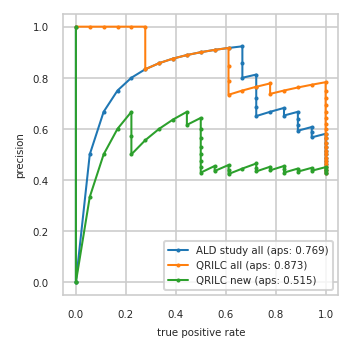

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.432 0.889
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.429 0.833
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.438 0.778
11         0.581 1.000     0.581 1.000     0.452 0.778
12         0.567 0.944     0.600 1.000     0.433 0.722
13         0.586 0.944     0.621 1.000     0.448 0.722
14         0.607 0.944     0.643 1.000     0.464 0.722
15         0.593 0.889     0.667 1.000     0.444 0.667
16         0.615 0.889     0.692 1.000     0.423 0.611
17         0.640 0.889     0.720 1.000     0.440 0.611
18         0.667 0.889     0.750 1.000     0.458 0.611
19         0.652 0.833     0.783 1.000     0.435 0.556
20         0.682 0.833     0.773 0.944     0.455 0.556
21         0.667 0.778     0.762 0.889     0.429 0.500
22         0.650 0.722     0.750 0.833     0.450 0.500
23         0.684 0.722     0.737 0.778     0.474 0.500
24         0.722 0.722     0.778 0.778     0.500 0.500
25         0.765 0.722     0.765 0.722     0.529 0.500
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.857 0.667     0.786 0.611     0.643 0.500
29         0.923 0.667     0.846 0.611     0.615 0.444
30         0.917 0.611     0.917 0.611     0.667 0.444
31         0.909 0.556     0.909 0.556     0.636 0.389
32         0.900 0.500     0.900 0.500     0.600 0.333
33         0.889 0.444     0.889 0.444     0.556 0.278
34         0.875 0.389     0.875 0.389     0.500 0.222
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


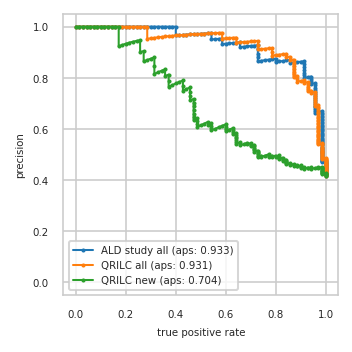

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


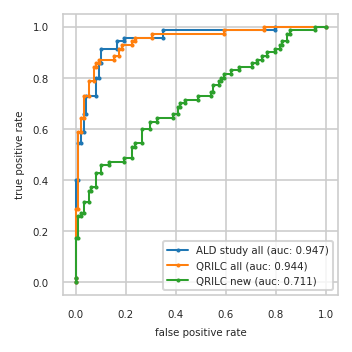

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}